In [2]:
!pip install kaggle --upgrade # Kaggle API를 최신 버전으로 설치
from google.colab import files
files.upload() # Kaggle API 토큰 파일(kaggle.json)을 업로드

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"leesanghyuck","key":"314b0a5afbee46ea358eb30291f433fd"}'}

In [3]:
!mkdir -p ~/.kaggle # Kaggle 폴더를 생성
!cp kaggle.json ~/.kaggle/ # 업로드한 kaggle.json 파일을 해당 폴더로 복사
!chmod 600 ~/.kaggle/kaggle.json # 권한을 설정
!ls -1ha kaggle.json # 파일이 제대로 폴더에 있는지 확인(존재하면 kaggle.json 파일의 이름을 출력)

kaggle.json


In [6]:
! kaggle datasets download -d awsaf49/asvpoof-2019-dataset

Dataset URL: https://www.kaggle.com/datasets/awsaf49/asvpoof-2019-dataset
License(s): ODC Attribution License (ODC-By)
... resuming from 6973030400 bytes (18348792744 bytes left) ...
100% 23.6G/23.6G [15:42<00:00, 24.2MB/s]
100% 23.6G/23.6G [15:42<00:00, 19.5MB/s]


In [7]:
!unzip asvpoof-2019-dataset.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: PA/PA/ASVspoof2019_PA_train/flac/PA_T_0049005.flac  
  inflating: PA/PA/ASVspoof2019_PA_train/flac/PA_T_0049006.flac  
  inflating: PA/PA/ASVspoof2019_PA_train/flac/PA_T_0049007.flac  
  inflating: PA/PA/ASVspoof2019_PA_train/flac/PA_T_0049008.flac  
  inflating: PA/PA/ASVspoof2019_PA_train/flac/PA_T_0049009.flac  
  inflating: PA/PA/ASVspoof2019_PA_train/flac/PA_T_0049010.flac  
  inflating: PA/PA/ASVspoof2019_PA_train/flac/PA_T_0049011.flac  
  inflating: PA/PA/ASVspoof2019_PA_train/flac/PA_T_0049012.flac  
  inflating: PA/PA/ASVspoof2019_PA_train/flac/PA_T_0049013.flac  
  inflating: PA/PA/ASVspoof2019_PA_train/flac/PA_T_0049014.flac  
  inflating: PA/PA/ASVspoof2019_PA_train/flac/PA_T_0049015.flac  
  inflating: PA/PA/ASVspoof2019_PA_train/flac/PA_T_0049016.flac  
  inflating: PA/PA/ASVspoof2019_PA_train/flac/PA_T_0049017.flac  
  inflating: PA/PA/ASVspoof2019_PA_train/flac/PA_T_0049018.flac  
  inflating: PA/PA/ASVspoof2019_PA_train

In [19]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay, roc_curve
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [21]:
base_path = 'LA/'
train_audio_files_path = os.path.join(base_path, 'LA/ASVspoof2019_LA_train/flac')
train_labels_path = os.path.join(base_path, 'LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt')
val_audio_files_path = os.path.join(base_path, 'LA/ASVspoof2019_LA_dev/flac')
val_labels_path = os.path.join(base_path, 'LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt')
test_audio_files_path = os.path.join(base_path, 'LA/ASVspoof2019_LA_eval/flac')
test_labels_path = os.path.join(base_path, 'LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt')


In [51]:
def readtxtfile(path):
    with open(path, 'r') as file:
        return file.read().splitlines()

def get_labels(path):
    text = readtxtfile(path)
    return {item.split(' ')[1]: item.split(' ')[-1] for item in text}

In [52]:
train_filename2label = get_labels(train_labels_path)
val_filename2label = get_labels(val_labels_path)
test_filename2label = get_labels(test_labels_path)

# 학습 데이터 생성
train_data = []
train_labels = []

for filename, label in tqdm(train_filename2label.items()):
    filepath = os.path.join(train_audio_files_path, filename + '.flac')
    audio, sample_rate = librosa.load(filepath, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    train_data.append(mfccs_mean)
    train_labels.append(label)

# 검증 데이터 생성
val_data = []
val_labels = []

for filename, label in tqdm(val_filename2label.items()):
    filepath = os.path.join(val_audio_files_path, filename + '.flac')
    audio, sample_rate = librosa.load(filepath, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    val_data.append(mfccs_mean)
    val_labels.append(label)

# 테스트 데이터 생성
test_data = []
test_labels = []

for filename, label in tqdm(test_filename2label.items()):
    filepath = os.path.join(test_audio_files_path, filename + '.flac')
    audio, sample_rate = librosa.load(filepath, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    test_data.append(mfccs_mean)
    test_labels.append(label)

# 데이터 및 레이블을 넘파이 배열로 변환
x_train = np.array(train_data)
y_train = np.array(train_labels)
x_val = np.array(val_data)
y_val = np.array(val_labels)
x_test = np.array(test_data)
y_test = np.array(test_labels)


  0%|          | 0/25380 [00:00<?, ?it/s]

  0%|          | 0/24844 [00:00<?, ?it/s]

  0%|          | 0/71237 [00:00<?, ?it/s]

In [108]:
# 모델 정의
model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(x_train.shape[1], 1)),
    MaxPooling1D(2),
    Dropout(0.5),
    LSTM(64),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 요약 정보 출력
# 레이블 변환
y_train = np.array([1 if label == 'spoof' else 0 for label in train_labels])
y_val = np.array([1 if label == 'spoof' else 0 for label in val_labels])
y_test = np.array([1 if label == 'spoof' else 0 for label in test_labels])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 38, 64)            256       
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 19, 64)            0         
 g1D)                                                            
                                                                 
 dropout_36 (Dropout)        (None, 19, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_37 (Dropout)        (None, 64)                0         
                                                                 
 dense_51 (Dense)            (None, 64)                4160      
                                                     

In [109]:
# 모델 학습

checkpoint = ModelCheckpoint('model_best.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_val, y_val),callbacks=[checkpoint, early_stopping])
# 모델 평가
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/30
794/794 [==============================] - ETA: 0s - loss: 0.2800 - accuracy: 0.8990
Epoch 1: val_loss improved from inf to 0.21568, saving model to model_best.h5
794/794 [==============================] - 10s 10ms/step - loss: 0.2800 - accuracy: 0.8990 - val_loss: 0.2157 - val_accuracy: 0.9093
Epoch 2/30
 15/794 [..............................] - ETA: 6s - loss: 0.2950 - accuracy: 0.8833

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


790/794 [============================>.] - ETA: 0s - loss: 0.2348 - accuracy: 0.9053
Epoch 2: val_loss did not improve from 0.21568
794/794 [==============================] - 8s 10ms/step - loss: 0.2348 - accuracy: 0.9054 - val_loss: 0.2775 - val_accuracy: 0.9049
Epoch 3/30
790/794 [============================>.] - ETA: 0s - loss: 0.2084 - accuracy: 0.9169
Epoch 3: val_loss improved from 0.21568 to 0.18063, saving model to model_best.h5
794/794 [==============================] - 7s 9ms/step - loss: 0.2082 - accuracy: 0.9170 - val_loss: 0.1806 - val_accuracy: 0.9283
Epoch 4/30
787/794 [============================>.] - ETA: 0s - loss: 0.1812 - accuracy: 0.9263
Epoch 4: val_loss did not improve from 0.18063
794/794 [==============================] - 7s 9ms/step - loss: 0.1806 - accuracy: 0.9266 - val_loss: 0.1872 - val_accuracy: 0.9262
Epoch 5/30
791/794 [============================>.] - ETA: 0s - loss: 0.1682 - accuracy: 0.9325
Epoch 5: val_loss did not improve from 0.18063
794/794 [=

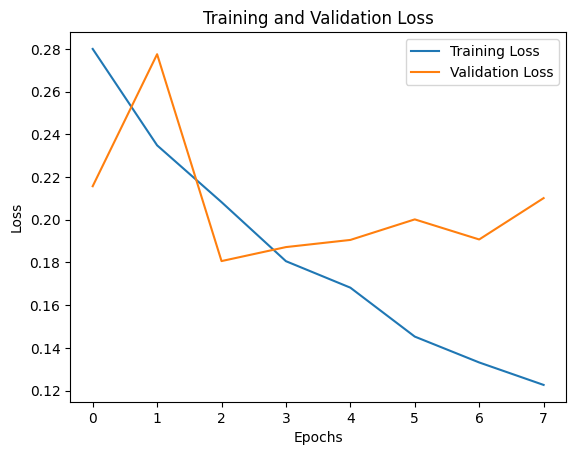

In [110]:
# 학습 및 검증 손실 시각화
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [111]:

# 검증 데이터에 대한 AUC 계산
val_preds = model.predict(x_val)
val_auc = roc_auc_score(y_val, val_preds)
print(f'Validation AUC Score: {val_auc}')

# 테스트 데이터에 대한 AUC 계산
test_preds = model.predict(x_test)
test_auc = roc_auc_score(y_test, test_preds)
print(f'Test AUC Score: {test_auc}')

# AUC 점수 시각화
plt.figure(figsize=(8, 5))

# 막대 그래프 그리기
bars = plt.bar(['Validation', 'Test'], [val_auc, test_auc], color=['blue', 'green'])

# AUC 점수 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), va='bottom')

plt.xlabel('Dataset')
plt.ylabel('AUC Score')
plt.title('AUC Score Comparison')
plt.ylim(0, 1)  # y축 범위를 0에서 1로 설정
plt.show()

777/777 [==============================] - 2s 2ms/step
Validation AUC Score: 0.9286679957235854
2227/2227 [==============================] - 7s 3ms/step


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [ ]:
# EER 계산
fpr, tpr, thresholds = roc_curve(y_test, test_preds)
eer_threshold = thresholds[np.argmin(np.abs(fpr - (1 - tpr)))]
eer_fpr = fpr[np.argmin(np.abs(fpr - (1 - tpr)))]
eer_tpr = tpr[np.argmin(np.abs(fpr - (1 - tpr)))]
eer = (eer_fpr + (1 - eer_tpr)) / 2
print(f'Equal Error Rate (EER): {eer} at threshold {eer_threshold}')